In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from diffusers import DDIMScheduler

try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *
except ModuleNotFoundError:
    import os; os.chdir("..")
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *

%load_ext autoreload
%autoreload 2

## Load the RadEdit Model here

In [4]:
from diffusers import DDIMScheduler, UNet2DConditionModel, StableDiffusionPipeline, AutoencoderKL
from transformers import AutoModel, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. UNet
unet = UNet2DConditionModel.from_pretrained("microsoft/radedit", subfolder="unet")

# 2. VAE
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae")

# 3. Text encoder and tokenizer
text_encoder = AutoModel.from_pretrained(
    "microsoft/BiomedVLP-BioViL-T",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/BiomedVLP-BioViL-T",
    model_max_length=128,
    trust_remote_code=True,
)

# 4. Scheduler
scheduler = DDIMScheduler(
    beta_schedule="linear",
    clip_sample=False,
    prediction_type="epsilon",
    timestep_spacing="trailing",
    steps_offset=1,
)

# 5. Pipeline
pipe = LocalStableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    requires_safety_checker=False,
    feature_extractor=None,
)

pipe = pipe.to(device)

/raid/s2198939/miniconda3/envs/demm2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The config attributes {'attention_type': 'default', 'dropout': 0.0, 'reverse_transformer_layers_per_block': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializin

In [3]:
# # load model
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# # model_id = "CompVis/stable-diffusion-v1-4"
# model_id = "/raid/s2198939/Diffusion_Memorization_HPO/OUTPUT_NORMAL_TRAINING/full"

# pipe = LocalStableDiffusionPipeline.from_pretrained(
#     model_id,
#     torch_dtype=torch.float16,
#     safety_checker=None,
#     requires_safety_checker=False,
# )
# pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# pipe = pipe.to(device)

The config attributes {'attention_type': 'default', 'dropout': 0.0, 'reverse_transformer_layers_per_block': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'force_upcast': True} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [5]:
num_inference_steps = 50
guidance_scale = 7.5
num_images_per_prompt = 4
image_size = 512

## Loading Memorized Prompts

In [7]:
os.getcwd()

'/raid/s2198939/diffusion_memorization'

In [6]:
df_zscore = pd.read_csv('det_outputs/outliers_zscore.csv')
df_percentile = pd.read_csv('det_outputs/outliers_percentile.csv')

In [7]:
prompt = df_zscore['prompt'][0]
print(prompt)
seed = 0

AP chest compared to ___:
 
 Previous mild pulmonary edema has resolved.  There is no pneumonia.  Several
 small lung nodules and the large right paratracheal mediastinal mass are
 manifestations of lung cancer.  Heart size normal.  No appreciable pleural
 effusion.


## Original Generation

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


  0%|          | 0/50 [00:00<?, ?it/s]

prompt: AP chest compared to ___:
 
 Previous mild pulmonary edema has resolved.  There is no pneumonia.  Several
 small lung nodules and the large right paratracheal mediastinal mass are
 manifestations of lung cancer.  Heart size normal.  No appreciable pleural
 effusion.


,,,

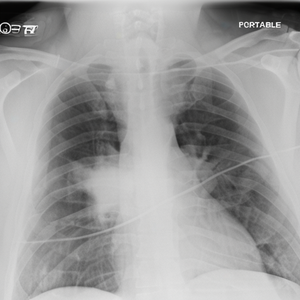
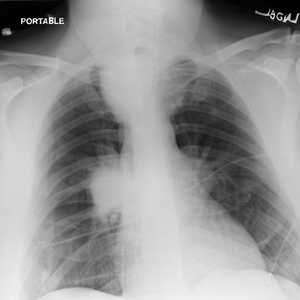
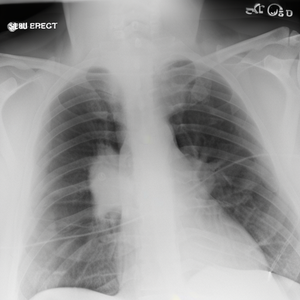
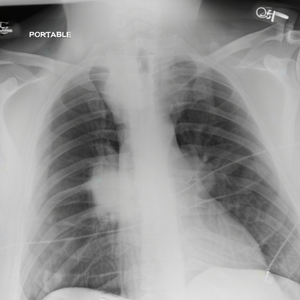

In [8]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt: {prompt}")
media.show_images(outputs, width=300)

## Getting Significance Score

  0%|          | 0/50 [00:00<?, ?it/s]

prompt:AP chest compared to ___:
 
 Previous mild pulmonary edema has resolved.  There is no pneumonia.  Several
 small lung nodules and the large right paratracheal mediastinal mass are
 manifestations of lung cancer.  Heart size normal.  No appreciable pleural
 effusion.


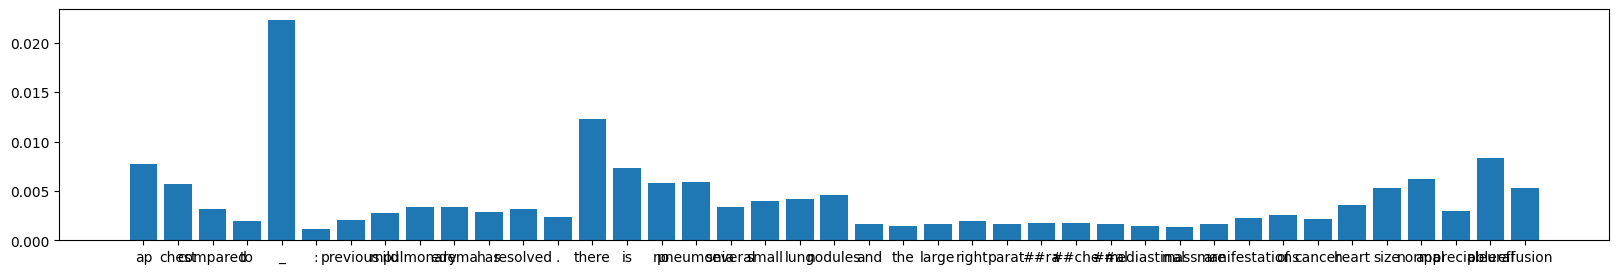

In [ ]:
# get token-wise grad norm
%matplotlib inline
set_random_seed(seed)
token_grads = pipe.get_text_cond_grad(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=4,
    target_steps=list(range(50)),
)
torch.cuda.empty_cache()

prompt_tokens = pipe.tokenizer.encode(prompt)
prompt_tokens = prompt_tokens[1:-1]
prompt_tokens = prompt_tokens[:75]
token_grads = token_grads[1:(1+len(prompt_tokens))]
token_grads = token_grads.cpu().tolist()

all_tokes = []

for curr_token in prompt_tokens:
    all_tokes.append(pipe.tokenizer.decode(curr_token))

print(f"### Prompt :{prompt}")
plt.figure(figsize=(20, 3))
plt.bar(all_tokes, token_grads)
plt.show()

## Modify the Prompt According to the Significance Scorre

In [7]:
prompt = "Emma Watson to play Belle in Disney's <i Beauty and the Beast i>"

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Emma Watson to play Belle in Disney's <i Beauty and the Beast i>


,,,

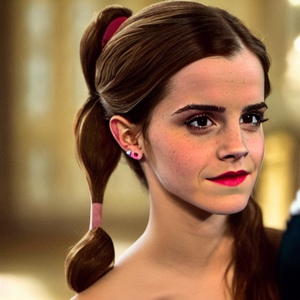
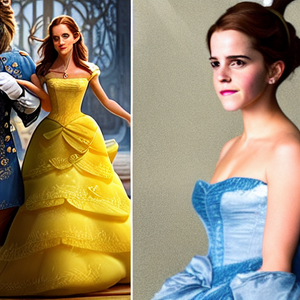
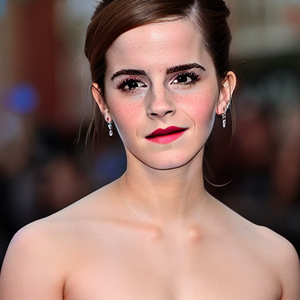
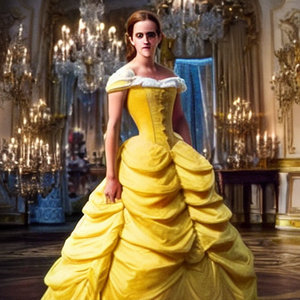

In [8]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt: {prompt}")
media.show_images(outputs, width=300)